## Imports

In [1]:
# Standard imports
import numpy as np
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
import seaborn as sns
import sys
import yaml
from time import process_time
import argparse
from pathlib import Path
import shutil
import json
from typing import List, Union
import gc
import zipfile
from pathlib import Path
import re

# Deep learning imports.
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset

import torchvision
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks, make_grid
from torchvision.ops import masks_to_boxes
import torchvision.transforms.functional as TF
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import torchmetrics

# Additional settings.
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

from he6_cres_deep_learning.daq import DAQ, Config

In [2]:
# import torch
# import pytorch_lightning as pl
# torch.__version__, pl.__version__

Drew's notebook uses `pl` version `1.6.4`, noted in case I run into errors later

## Introducing scattering to Drew's sim

#### Function to create the DataFrame of files/events and target boundary boxes

In [3]:
def simple_fasterrcnn_df(n_files, n_events_per_file, spec_length=.035, freq_bw=1200e6, slope_mean=2e8, slope_std=1e7, seed=1234):
    '''
    Define the DataFrame describing the simulation of various events over several spec files. Entries are track(?)-level description of
    the electron's motion in the CRES apparatus. 
    Returns a tuple of DataFrames, one the track information and the other the bounding boxes
    '''
    track_set = {
            "file_in_acq": [],
            "event_num": [],
            "time_start": [],
            "time_stop": [],
            "freq_start": [],
            "freq_stop": [],
            "slope": [],
            "band_power_start": [],
            "band_power_stop": [],
            "band_num": [],
        }
    
    # Dictionary to store event boundary boxes for each file
    event_bboxes = {
        0: # key will be file number
            {0: # value will be a dict, where key is event number (this will grow through sim)
                 []} # value of the inner dict will be the boundary box coordinates 
                     # in format [start_time, start_freq, stop_time, stop_freq]
    }
    
    # Define Generator object for pulling from distributions
    rng = np.random.default_rng(seed)
    
    # n_events in a spec file can be reasonably estimated from a Poisson distribution
    n_events = rng.poisson(lam=3, size=n_files) 
    
    # Loop over files
    for file, events in enumerate(n_events): 
        # check if file in keys for bboxes, if not then initialize dict
        if file not in event_bboxes.keys():
            event_bboxes[file] = {0: []}

        # Pull from uniform distribution to determine start time of event
        event_start_times = rng.uniform(low=0, high=spec_length, size=events)
        
#-------------------------------------------------------------------------------------------------------------------------
        # Get start frequencies
        # TODO: implement beta spectrum sampling for start frequencies
        event_start_frequencies = rng.uniform(low=150e6, high=freq_bw, size=events)
#-------------------------------------------------------------------------------------------------------------------------

        # Loop over each event in file
        for event, (start_time, start_freq) in enumerate(zip(event_start_times, event_start_frequencies)):
            # check if event in keys for bboxes, if not then initialize list
            if event not in event_bboxes[file].keys():
                event_bboxes[file][event] = []
#-------------------------------------------------------------------------------------------------------------------------
            # Define number of scatters per event
            # TODO: Implement a physical model for scattering
            n_tracks = rng.integers(low=1, high = 10)
#-------------------------------------------------------------------------------------------------------------------------

            # Loop over each track in event
            for track in range(n_tracks):
                # Defining break parameter if need to leave loop because we hit edge of spec file
                _break = False
                
                # Pull track length from exponential distribution with tau=10ms
                track_len = rng.exponential(scale=.01)
                
                # Check to see if track outside of time window
                if start_time+track_len > spec_length:
                    stop_time = spec_length
                    track_len = spec_length-start_time
                    _break = True
                else:
                    stop_time = start_time+track_len
    
                # Slope of track is assumed to be normally distributed around the mean of 2e8Hz in Kr83 events
                slope = rng.normal(loc=slope_mean, scale=slope_std)
                
                # Check if track outside of bandwidth
                if start_freq + slope*track_len > freq_bw:
                    stop_freq = freq_bw
                    _break = True
                else:
                    stop_freq = start_freq+slope*track_len

                # Store parameters in dict
                track_set["file_in_acq"].append(file)
                track_set["event_num"].append(event)
                track_set["time_start"].append(start_time)
                track_set["time_stop"].append(stop_time)
                track_set["slope"].append(slope)
                track_set["freq_start"].append(start_freq)
                track_set["freq_stop"].append(stop_freq)
                
                # If first track in event, add start_time, start_freq to bboxes dict
                if track==0:
                    event_bboxes[file][event].append(start_time)
                    event_bboxes[file][event].append(start_freq)
                
                # If hit edge then break out of track loop for this event, append bbox values
                if _break:
                    event_bboxes[file][event].append(stop_time)
                    event_bboxes[file][event].append(stop_freq)
                    break
                # Else update start time and freq. 
                # Frequency jump will be pulled from normal dist mean 10MHZ std 2MHz
                
                # If reached number of tracks in event then append bbox values
                elif track==n_tracks-1:
                    event_bboxes[file][event].append(stop_time)
                    event_bboxes[file][event].append(stop_freq)
                
                # Else update start time and freq. 
                # Frequency jump will be pulled from normal dist mean 10MHZ std 2MHz
                else:
                    start_time = stop_time
                    start_freq = stop_freq + rng.normal(loc=10e6, scale=2e6)
    
#-------------------------------------------------------------------------------------------------------------------------   
    # TODO: implement proper power information
    track_set["band_power_start"] = [1e-14]*len(track_set["slope"])
    track_set["band_power_stop"] = [1e-14]*len(track_set["slope"])
    track_set["band_num"] = np.zeros(len(track_set["slope"]))
#-------------------------------------------------------------------------------------------------------------------------
    
    # convert track_set dict to DataFrame
    track_set = pd.DataFrame(track_set)
    
    # define track bbox DataFrame
    track_bboxes = track_set.loc[:,("file_in_acq", "event_num")].copy()
    bbox_list = []
    
    # define counter to keep up with total tracks for indexing
    tot_tracks=0
    for file in event_bboxes.keys():
        for event in event_bboxes[file].keys():
            n_tracks = track_set[(track_set["file_in_acq"]==file) &\
                                 (track_set["event_num"]==event)].shape[0]
            for track in range(n_tracks):
                bbox_list.append(event_bboxes[file][event])
                if track==n_tracks-1:
                    tot_tracks += n_tracks
                    
    track_bboxes['bbox'] = bbox_list

    return track_set, track_bboxes, event_bboxes

#### Some simple sanity checks

In [4]:
simple_df, bboxes, bboxes_dict = simple_fasterrcnn_df(10,3)

In [6]:
bboxes.head(10)

file_in_acq  event_num                                               bbox
0            0          0  [0.0129677950419741, 713394548.5888778, 0.035,...
1            0          0  [0.0129677950419741, 713394548.5888778, 0.035,...
2            0          0  [0.0129677950419741, 713394548.5888778, 0.035,...
3            0          1  [0.016893430295484752, 919893233.7293808, 0.03...
4            0          1  [0.016893430295484752, 919893233.7293808, 0.03...
5            0          1  [0.016893430295484752, 919893233.7293808, 0.03...
6            0          2  [0.0032263541396897947, 621356328.357728, 0.03...
7            0          2  [0.0032263541396897947, 621356328.357728, 0.03...
8            0          2  [0.0032263541396897947, 621356328.357728, 0.03...
9            0          2  [0.0032263541396897947, 621356328.357728, 0.03...

In [7]:
simple_df.tail(20)

file_in_acq  event_num  time_start  time_stop    freq_start     freq_stop  \
72            7          4    0.015416   0.023663  1.047130e+09  1.048639e+09   
73            7          4    0.023663   0.035000  1.058023e+09  1.060156e+09   
74            8          0    0.005686   0.028723  6.412554e+08  6.460368e+08   
75            8          0    0.028723   0.028857  6.567609e+08  6.567858e+08   
76            8          0    0.028857   0.035000  6.649209e+08  6.661108e+08   
77            8          1    0.012416   0.035000  9.652990e+08  9.699771e+08   
78            8          2    0.008598   0.012028  1.906085e+08  1.912789e+08   
79            8          2    0.012028   0.017515  1.999948e+08  2.010617e+08   
80            8          2    0.017515   0.021920  2.087968e+08  2.097202e+08   
81            8          2    0.021920   0.026641  2.227313e+08  2.236899e+08   
82            9          0    0.006266   0.035000  7.676101e+08  7.733846e+08   
83            9          1    0.031957   0.034536  1.087641e+09  1.088150e+09   
84            9          1    0.034536   0.035000  1.100363e+09  1.100461e+09   
85            9          2    0.007240   0.009267  9.195430e+08  9.199342e+08   
86            9          2    0.009267   0.024817  9.313629e+08  9.345143e+08   
87            9          2    0.024817   0.035000  9.455310e+08  9.474462e+08   
88            9          3    0.012744   0.035000  1.140813e+09  1.145371e+09   
89            9          4    0.006339   0.011810  3.545231e+08  3.555610e+08   
90            9          4    0.011810   0.035000  3.636555e+08  3.680486e+08   
91            9          5    0.020480   0.035000  4.031335e+08  4.060105e+08   

           slope  band_power_start  band_power_stop  band_num  
72  1.830135e+08      1.000000e-14     1.000000e-14       0.0  
73  1.881540e+08      1.000000e-14     1.000000e-14       0.0  
74  2.075533e+08      1.000000e-14     1.000000e-14       0.0  
75  1.847157e+08      1.000000e-14     1.000000e-14       0.0  
76  1.937087e+08      1.000000e-14     1.000000e-14       0.0  
77  2.071442e+08      1.000000e-14     1.000000e-14       0.0  
78  1.954344e+08      1.000000e-14     1.000000e-14       0.0  
79  1.944537e+08      1.000000e-14     1.000000e-14       0.0  
80  2.096463e+08      1.000000e-14     1.000000e-14       0.0  
81  2.030357e+08      1.000000e-14     1.000000e-14       0.0  
82  2.009648e+08      1.000000e-14     1.000000e-14       0.0  
83  1.976656e+08      1.000000e-14     1.000000e-14       0.0  
84  2.112867e+08      1.000000e-14     1.000000e-14       0.0  
85  1.929704e+08      1.000000e-14     1.000000e-14       0.0  
86  2.026629e+08      1.000000e-14     1.000000e-14       0.0  
87  1.880721e+08      1.000000e-14     1.000000e-14       0.0  
88  2.047816e+08      1.000000e-14     1.000000e-14       0.0  
89  1.897028e+08      1.000000e-14     1.000000e-14       0.0  
90  1.894401e+08      1.000000e-14     1.000000e-14       0.0  
91  1.981332e+08      1.000000e-14     1.000000e-14       0.0

In [8]:
simple_df['time_stop'].max(),simple_df['freq_stop'].max()/1e6

(0.035, 1177.3688832508747)

In [9]:
# for column in simple_df.columns:
#     simple_df[column].plot(kind='hist', title=column)
#     plt.show()

#### Plotting tracks and bboxes

In [10]:
def plot_tracks_and_bboxes(tracks, file_in_acq, freq_bw, draw_bbox=False, bbox_list=[]):

    condition = tracks.file_in_acq == file_in_acq

    fig, ax = plt.subplots(figsize=(12, 8))

    for index, row in tracks[condition].iterrows():

        time_coor = np.array([row["time_start"], row["time_stop"]])
        freq_coor = np.array([row["freq_start"], row["freq_stop"]])

        ax.plot(
            time_coor,
            freq_coor,
            "ro-",
            markersize=0.5,
            alpha=0.5,
        )
    ax.set_ylim(0, freq_bw)
    ax.set_title("tracks")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Freq (Hz)")
    
    if draw_bbox:
        for bbox in bbox_list:
            width = bbox[2]-bbox[0]
            height = bbox[3]-bbox[1]
            ax.add_patch(Rectangle(bbox[:2], width, height, alpha=.1))
    # ax.set_ylim([6.275e10, 6.28e10])
    # ax.set_ylim([9.65298e8, 9.69978e8])
    plt.show()

    return None

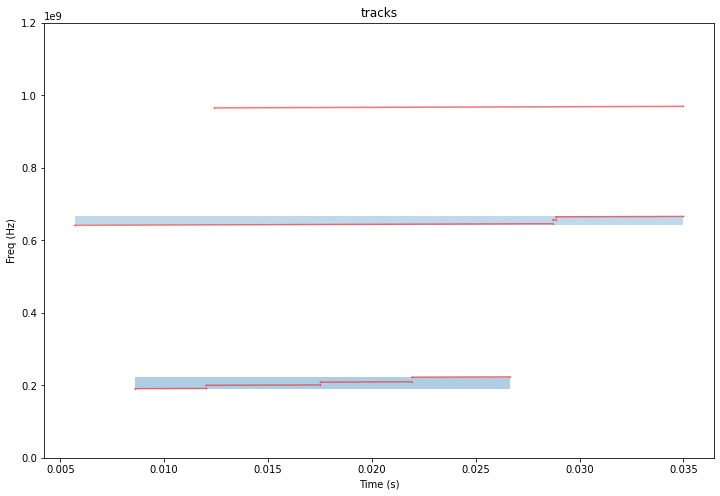

In [11]:
plot_tracks_and_bboxes(simple_df, 8, 1200e6, True, bboxes[bboxes['file_in_acq']==8]['bbox'].values)

## Figuring out the spec file generation

In [12]:
def congifure_gain_noise_csv_simple(csv_path):
    """
    Note that if you don't change the noise here you will end up with the default noise
    floor of the apparatus (I-side).
    """
    # Sinusoidal gain:
    col = "gain"

    array = np.array([1.0] * 4096)
    update_gain_noise_csv(csv_path, col, array)

    # Flat noise:
    col = "noise_mean"

    array = np.array([1.0] * 4096)

    update_gain_noise_csv(csv_path, col, array)

def update_gain_noise_csv(csv_path, col, array):
    """
    Helper function for editing gain_noise.csv.
    """
    noise_gain_df = pd.read_csv(csv_path)
    noise_gain_df[col] = array
    noise_gain_df.to_csv(csv_path, index=False)

    return None

In [13]:
# ---- Copy and rename base config ----
name = "fasterRCNN_ds"
config_path = '/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/config/base_daq_config.yaml'
config_path = Path(config_path)
config_path_simple = config_path.with_name(name + config_path.suffix)
shutil.copyfile(str(config_path), str(config_path_simple))

# ---- Copy then alter base noise_gain file to make it simpler. ----

'/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/config/fasterRCNN_ds.yaml'

In [14]:
# Step 0: make a copy of the gain noise file.
gain_noise_path = '/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/gain_noise/base_gain_noise.csv'
gain_noise_path = Path(gain_noise_path)
gain_noise_path_simple = gain_noise_path.with_name(
    gain_noise_path.stem + f"_{name}" + gain_noise_path.suffix
)
shutil.copyfile(str(gain_noise_path), str(gain_noise_path_simple))

'/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/gain_noise/base_gain_noise_fasterRCNN_ds.csv'

In [15]:
# Step 1: alter the gain_noise file.
congifure_gain_noise_csv_simple(gain_noise_path_simple)

# ---- Build spec files ----
config = Config(config_path_simple)
config.daq

{'spec_length': 0.035,
 'freq_bw': 1200000000.0,
 'freq_bins': 4096,
 'roach_avg': 2,
 'requant_gain': 20,
 'base_gain': 100000000000.0,
 'rng_seed': 123456,
 'build_labels': False,
 'waveguide_side"': 'I',
 'gain_noise_csv_path': '/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/demo/gain_noise/base_gain_noise.csv',
 'spec_prefix': 'test'}

In [16]:
# # Change default settings of config to match input args.
# config.daq.gain_noise_csv_path = gain_noise_path_simple
# config.daq.random_seed = random_seed
# config.daq.spec_length = spec_length

In [17]:
# Extract necessary parameters from config.
spec_length = config.daq.spec_length
freq_bw = config.daq.freq_bw

# Build the track set to be simulated.
tracks, _, target_dict = simple_fasterrcnn_df(
    n_files=2, n_events_per_file=3
)

tracks

file_in_acq  event_num  time_start  time_stop    freq_start     freq_stop  \
0            0          0    0.011149   0.035000  7.903643e+08  7.946196e+08   
1            0          1    0.033743   0.034212  1.056802e+09  1.056904e+09   
2            0          1    0.034212   0.035000  1.067945e+09  1.068104e+09   
3            0          2    0.009228   0.011306  1.056946e+09  1.057337e+09   
4            0          2    0.011306   0.013035  1.068730e+09  1.069075e+09   
5            0          3    0.015435   0.022837  8.586254e+08  8.600554e+08   
6            0          3    0.022837   0.035000  8.688144e+08  8.712785e+08   
7            1          0    0.005372   0.026116  1.191872e+09  1.195755e+09   
8            1          0    0.026116   0.028668  1.203094e+09  1.200000e+09   

          slope  band_power_start  band_power_stop  band_num  
0  1.784086e+08      1.000000e-14     1.000000e-14       0.0  
1  2.173329e+08      1.000000e-14     1.000000e-14       0.0  
2  2.026835e+08      1.000000e-14     1.000000e-14       0.0  
3  1.884259e+08      1.000000e-14     1.000000e-14       0.0  
4  1.996758e+08      1.000000e-14     1.000000e-14       0.0  
5  1.932075e+08      1.000000e-14     1.000000e-14       0.0  
6  2.025884e+08      1.000000e-14     1.000000e-14       0.0  
7  1.871687e+08      1.000000e-14     1.000000e-14       0.0  
8  1.975278e+08      1.000000e-14     1.000000e-14       0.0

In [18]:
# Build the simulated spec files.
daq = DAQ(config)
daq.run(tracks)

Building spec file 0. 0.035 s, 5126 slices.
file = 0, slices = [0:400]
file = 0, slices = [400:800]
file = 0, slices = [800:1200]
file = 0, slices = [1200:1600]
file = 0, slices = [1600:2000]
file = 0, slices = [2000:2400]
file = 0, slices = [2400:2800]
file = 0, slices = [2800:3200]
file = 0, slices = [3200:3600]
file = 0, slices = [3600:4000]
file = 0, slices = [4000:4400]
file = 0, slices = [4400:4800]
file = 0, slices = [4800:5126]
Time to build file 0: 12.614 s 

Building spec file 1. 0.035 s, 5126 slices.
file = 1, slices = [0:400]
file = 1, slices = [400:800]
file = 1, slices = [800:1200]
file = 1, slices = [1200:1600]
file = 1, slices = [1600:2000]
file = 1, slices = [2000:2400]
file = 1, slices = [2400:2800]
file = 1, slices = [2800:3200]
file = 1, slices = [3200:3600]
file = 1, slices = [3600:4000]
file = 1, slices = [4000:4400]
file = 1, slices = [4400:4800]
file = 1, slices = [4800:5126]
Time to build file 1: 7.142 s 

Done building spec files. 


#### Ok, can build spec files with Drew's functions. Let's write some json files with the target bbox dicts.

In [19]:
def write_label_files(target_dict, path_to_target_dir, spec_prefix):
    with open(f'{path_to_target_dir}/{spec_prefix}_labels.json', 'w') as file:
        json.dump(target_dict, file)

In [20]:
config_path.parent

PosixPath('/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/config')

In [21]:
labels_path = str(config_path.parent.joinpath(name, 'label_files'))
config.daq.spec_prefix

'test'

In [22]:
write_label_files(target_dict, labels_path, config.daq.spec_prefix)

#### Ok, got some json files with bboxes. Let's check the spec files then move on.

In [36]:
spec_path = daq.spec_file_paths[0]
spec_array = daq.spec_to_array(spec_path, slices = -1)

(5126, 4096)


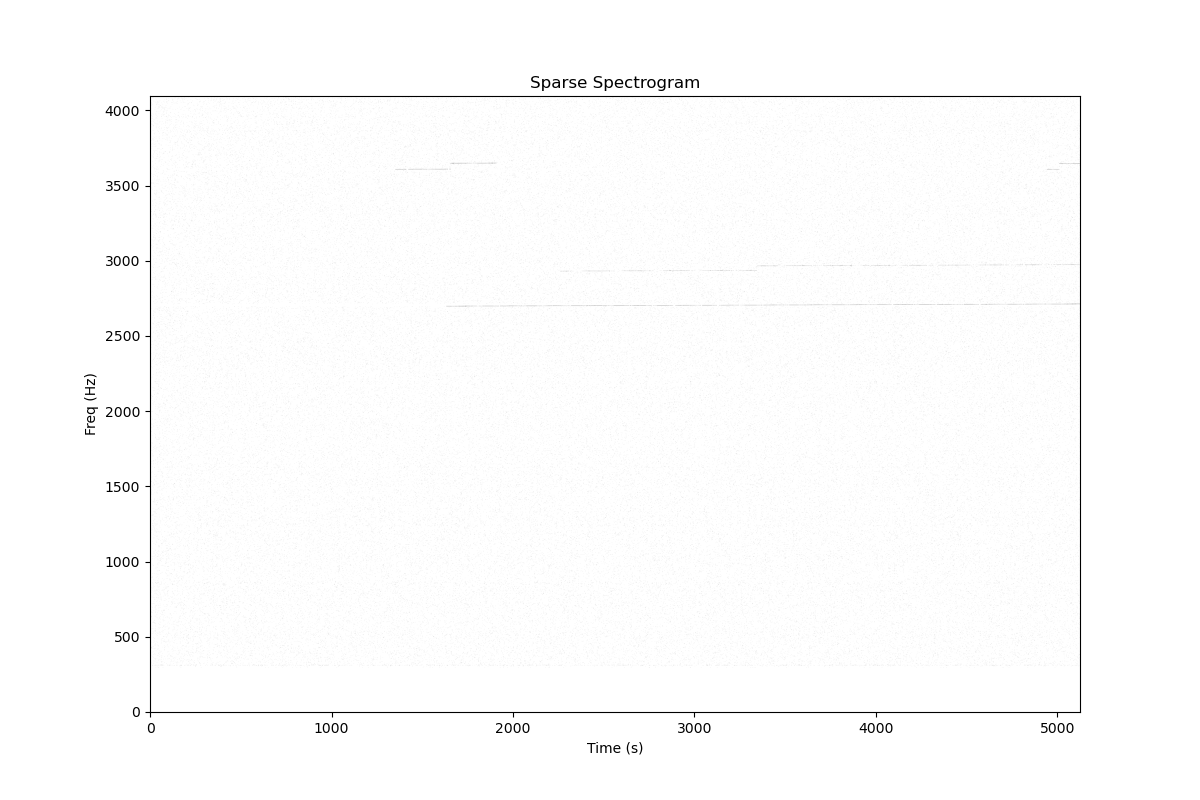

In [24]:
%matplotlib widget

cut_condition = np.array((spec_array > spec_array.mean(axis=0)*5).T , dtype = float)

fig, ax = plt.subplots(figsize=(12,8))

ax.imshow(1-cut_condition,origin='lower', aspect='auto', interpolation=None, cmap = "gray")

ax.set_title("Sparse Spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Freq (Hz)")
plt.show()

## PyTorch-Lightning DataModule

#### Start with getting a Dataset

In [291]:
class CRES_Dataset(torch.utils.data.Dataset):
    """DOCUMENT."""

    def __init__(
        self, root_dir, freq_bins=4096, max_pool=3, file_max=10, transform=None
    ):
        """
        Args:
            root_dir (string): Directory with all the spec files and targets.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.root_dir = root_dir
        self.freq_bins = freq_bins
        self.max_pool = max_pool
        self.file_max = file_max
        self.transform = transform

        self.imgs, self.targets = self.collect_imgs_and_targets()

        # Guarentee the correct type.
        self.imgs = self.imgs.type(torch.ByteTensor)
        # , self.targets = , self.targets.long()

        # Targets don't need the color dimension.
        # self.targets = self.targets.squeeze(1)

        return None

    def __getitem__(self, idx):

        img = self.imgs[idx]
        target = self.targets[idx]

        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):

        return len(self.imgs)

    def collect_imgs_and_targets(self):

        img_dir = self.root_dir + "/spec_files"
        target_dir = self.root_dir + "/label_files"

        # TODO: make it so directories get spec_prefix instead of files
        imgs, exp_name = self.load_spec_dir(img_dir)
#---------------------------------------------------------------------------------------------------        
        # Is this really the best way to scale the bboxes?
        targets = self.load_target_dir(target_dir, exp_name, imgs[0][0].shape)
        # targets = targets.long()

        return imgs, targets

    def load_spec_dir(self, dir_path):
        """
        Loads all of the images in a directory into torch images.

        Args:
            dir_path (str): path should point to a directory that only contains
                .JPG images. Or any image type compatible with cv2.imread().

            resize_factor (float): how to resize the image. Often one would
                like to reduce the size of the images to be easier/faster to
                use with our maskrcnn model.

        Returns:
            imgs (List[torch.ByteTensor[3, H, W]]): list of images (each a
                torch.ByteTensor of shape(3, H, W)).
        """
        path_glob = Path(dir_path).glob("**/*")
        files = [x for x in path_glob if x.is_file()]
        file_names = [str(x.name) for x in files]
        files = [str(x) for x in files]
        
        # extract experiment name to match to target file 
        exp_name = list(set(re.findall(r'[a-zA-Z0-9]+', name)[0] for name in file_names))
        
        # Extract the file index from the file name.
        file_idxs = [int(re.findall(r"\d+", name)[0]) for name in file_names]

        # Sort the files list based on the file_idx.
        files = [
            file
            for (file, file_idx) in sorted(
                zip(files, file_idxs), key=lambda pair: pair[1]
            )
        ]

        # Maxpool to use on images and labels.
        maxpool = nn.MaxPool2d(self.max_pool, self.max_pool, return_indices=False)

        if len(files) == 0:
            raise UserWarning("No files found at the input path.")

        imgs = []
        for file in files[: self.file_max]:

            img = self.spec_to_numpy(file)
            img = torch.from_numpy(img).unsqueeze(0)
            img = img.permute(0, 2, 1)

            # Apply max pooling now so we never have to hold the large images.

            imgs.append(maxpool(img.float()))

        imgs = torch.stack(imgs)

        return imgs, exp_name
    
    def load_target_dir(self, dir_path, exp_name, spec_shape): # spec_shape[0] is frequency, spec_shape[1] is time
        """
        TODO: Document
        Load bbox json files
        """
        path_glob = Path(dir_path).glob(f"{exp_name}*")
        files = [x for x in path_glob if x.is_file()]
        files = [str(x) for x in files]

        # Maxpool to use on images and labels.
        # maxpool = nn.MaxPool2d(self.max_pool, self.max_pool, return_indices=False)

        if len(files) == 0:
            raise UserWarning("No files found at the input path.")
        
        # targets will be a list of dicts that contain the bboxes, labels, and scores
        targets = []
        targets_dict = {'boxes': [],
                        'labels': []}
        for file in files[: self.file_max]:
            # Apply max pooling now so we never have to hold the large images.
            # imgs.append(maxpool(img.float()))
            
            # read all bboxes for experiment
            with open(file, 'r') as f:
                bboxes = json.load(f)
                
                # each value corresponds to a file number
                for file_num, bbox_dict in bboxes.items():
                    # make sure we've populated the dict at least once before appending to list
                    if file_num != '0':
                        targets.append(targets_dict)
                        targets_dict = {'boxes': [],
                                        'labels': []}
                        
                    # each bbox corresponds to an event in the file
                    for bbox in bbox_dict.values():
                        bbox[0] *= spec_shape[1]/0.035
                        bbox[2] *= spec_shape[1]/0.035
                        bbox[1] *= spec_shape[0]/1.2e9
                        bbox[3] *= spec_shape[0]/1.2e9
                        targets_dict['boxes'].append(torch.tensor(bbox))
                        targets_dict['labels'].append(torch.tensor([1]))
                        
        targets.append(targets_dict)
        targets_dict = {'boxes': [],
                        'labels': []}
        return targets
        

    def spec_to_numpy(
        self, spec_path, slices=-1, packets_per_slice=1, start_packet=None
    ):
        """
        TODO: Document.
        Making this just work for one packet per spectrum because that works for simulation in Katydid.
        * Make another function that works with 4 packets per spectrum (for reading the Kr data).
        """

        BYTES_IN_PAYLOAD = self.freq_bins
        BYTES_IN_HEADER = 32
        BYTES_IN_PACKET = BYTES_IN_PAYLOAD + BYTES_IN_HEADER

        if slices == -1:
            spec_array = np.fromfile(spec_path, dtype="uint8", count=-1).reshape(
                (-1, BYTES_IN_PACKET)
            )[:, BYTES_IN_HEADER:]
        else:
            spec_array = np.fromfile(
                spec_path, dtype="uint8", count=BYTES_IN_PAYLOAD * slices
            ).reshape((-1, BYTES_IN_PACKET))[:, BYTES_IN_HEADER:]
        
        if packets_per_slice > 1:

            spec_flat_list = [
                spec_array[(start_packet + i) % packets_per_slice :: packets_per_slice]
                for i in range(packets_per_slice)
            ]
            spec_flat = np.concatenate(spec_flat_list, axis=1)
            spec_array = spec_flat

        return spec_array

In [292]:
root_dir = str(config_path.parent.joinpath('fasterRCNN_ds'))

In [293]:
cres = CRES_Dataset(root_dir)
cres.imgs.shape, cres.targets

(torch.Size([2, 1, 1365, 1708]),
 [{'boxes': [tensor([ 544.0560,  899.0394, 1708.0000,  903.8798]),
    tensor([1646.6473, 1202.1127, 1708.0000, 1214.9686]),
    tensor([ 450.3139, 1202.2755,  636.0941, 1216.0726]),
    tensor([ 753.2385,  976.6863, 1708.0000,  991.0793])],
   'labels': [tensor([1]), tensor([1]), tensor([1]), tensor([1])]},
  {'boxes': [tensor([ 262.1339, 1355.7546, 1398.9856, 1365.0000])],
   'labels': [tensor([1])]}])

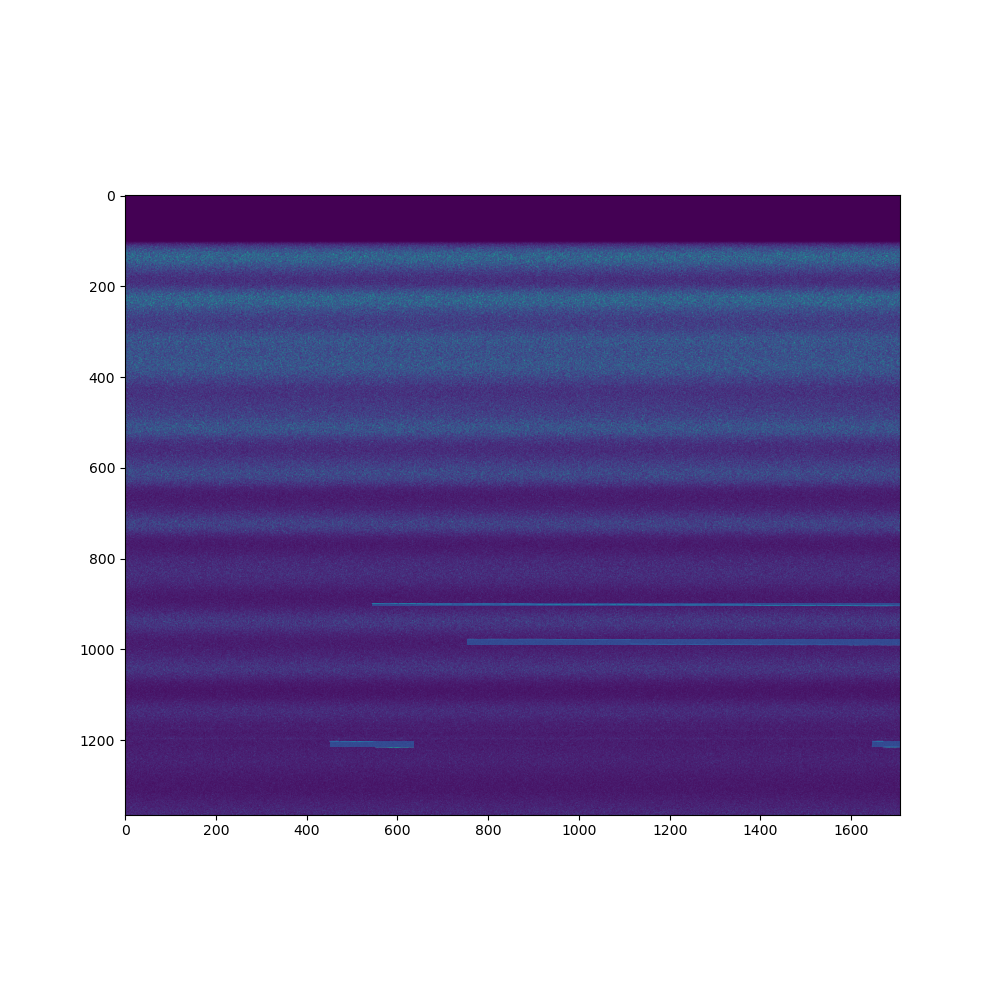

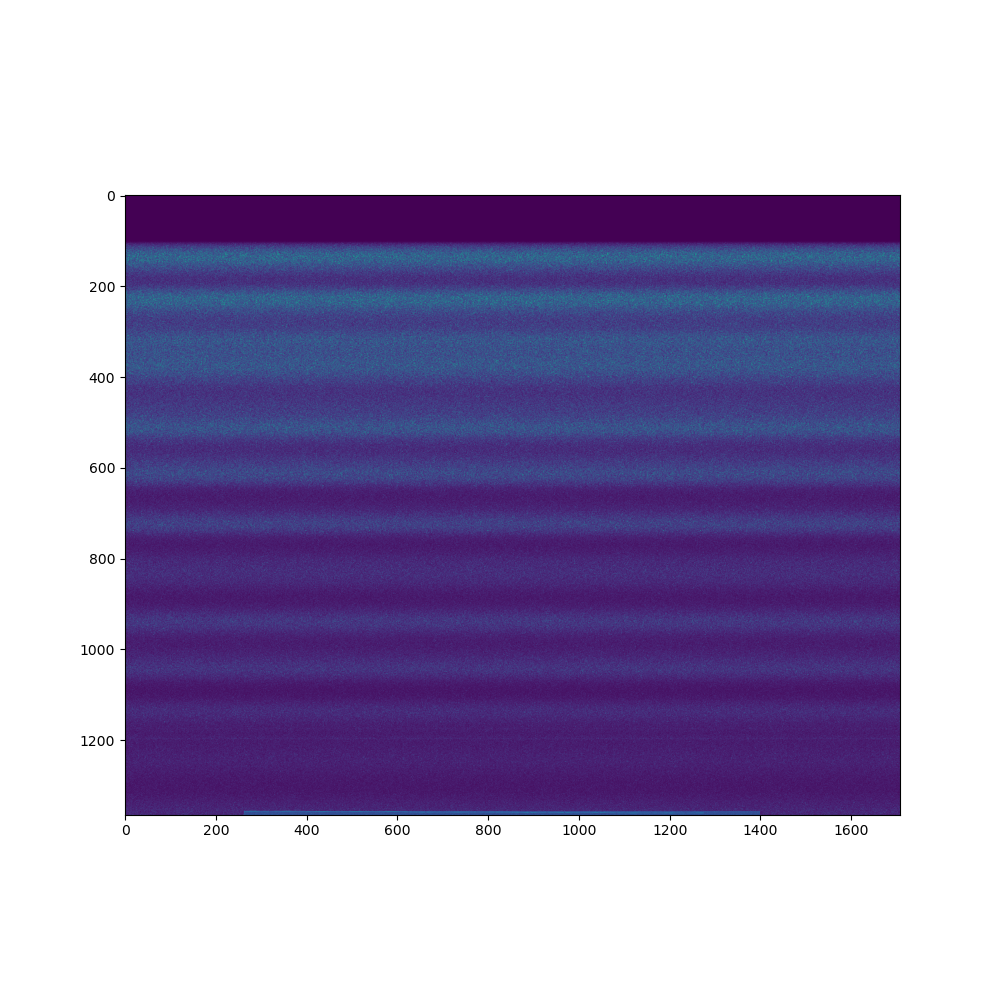

In [303]:
for i, (image, target_dict) in enumerate(zip(cres.imgs, cres.targets)):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(image[0])
    for target in target_dict['boxes']:
        width = target[2]-target[0]
        height = target[3]-target[1]
        ax.add_patch(Rectangle(target, width, height, alpha=.5))
    plt.show()

In [304]:
class ObjectDetection_DM(pl.LightningDataModule):
    """
    Self contained PyTorch Lightning DataModule for testing object detection
    and image segmentation models with PyTorch Lightning. Uses the torch
    dataset ObjectDetection_DS.

    Args:
        train_val_size (int): total size of the training and validation
            sets combined.
        train_val_split (Tuple[float, float]): should sum to 1.0. For example
            if train_val_size = 100 and train_val_split = (0.80, 0.20)
            then the training set will contain 80 imgs and the validation
            set will contain 20 imgs.
        test_size (int): the size of the test data set.
        batch_size (int): batch size to be input to dataloaders. Applies
            for training, val, and test datasets.
        dataloader_shuffle (Dict): whether or not to shuffle for each of
            the three dataloaders. Dict must contain the keys: "train",
            "val", "test".
        img_size (int): will build images of shape (3, img_size, img_size).
        shapes_per_image (Tuple[int, int]): will produce images containing
            minimum number of shapes Tuple[0] and maximum number of shapes
            Tuple[1]. For example shapes_per_image = (2,2) would create a
            dataset where each image contains exactly two shapes.
        class_probs (Tuple[float, float, float]): relative probability of
            each shape occuring in an image. Need not sum to 1. For example
            class_probs = (1,1,0) will create a dataset with 50% class 1
            shapes, 50% class 2 shapes, 0% class 3 shapes.
        rand_seed (int): used to instantiate a numpy rng.
        class_map (Dict[Dict]): the class map must contain keys (0,1,2,3)
            and contain names "background", "rectangle", "line", and "donut".
            "gs_range" specifies the upper and lower bound of the
            grayscale values (0, 255) used to color the shapes.
            "target_color" can be used by visualization tools to assign
            a color to masks and boxes. Note that class 0 is reserved for
            background in most instance seg models, so one can rearrange
            the class assignments of different shapes but 0 must correspond
            to "background". The utility of this Dict is to enable the user
            to change target colors, class assignments, and shape
            intensities. A valid example:
            class_map={
            0: {"name": "background","gs_range": (200, 255),"target_color": (255, 255, 255),},
            1: {"name": "rectangle", "gs_range": (0, 100), "target_color": (255, 0, 0)},
            2: {"name": "line", "gs_range": (0, 100), "target_color": (0, 255, 0)},
            3: {"name": "donut", "gs_range": (0, 100), "target_color": (0, 0, 255)}}.
        target_masks (bool): whether or not the target dictionaries should
            contain boolean masks for each object instance. Masks are not
            necessary to train FasterRCNN or other object detection models
            but are necessary to train instance segmentation models such
            as MaskRCNN.
    """

    def __init__(
        self,
        train_val_size=100,
        train_val_split=(0.80, 0.20),
        test_size=10,
        batch_size=8,
        dataloader_shuffle={"train": True, "val": False, "test": False},
        img_size=50,
        shapes_per_image=(1, 3),
        class_probs=(1, 1, 1),
        rand_seed=12345,
        class_map={
            0: {
                "name": "background",
                "gs_range": (200, 255),
                "target_color": (255, 255, 255),
            },
            1: {"name": "event", "gs_range": (0, 100), "target_color": (255, 0, 0)},
            2: {"name": "track", "gs_range": (0, 100), "target_color": (0, 255, 0)}
        },
        target_masks=False,
    ):

        super().__init__()

        if sorted(list(dataloader_shuffle.keys())) != sorted(["train", "val", "test"]):
            raise ValueError(
                "Dict dataloader_shuffle must contain the keys: train, val, test."
            )
        # Attributes to define datamodule.
        self.train_val_size = train_val_size
        self.train_val_split = np.array(train_val_split)
        self.train_val_sizes = np.array(
            self.train_val_size * self.train_val_split, dtype=int
        )
        self.test_size = test_size
        self.batch_size = batch_size
        self.dataloader_shuffle = dataloader_shuffle

        # Attributes to define dataset.
        self.img_size = img_size
        self.rand_seed = rand_seed
        self.shapes_per_image = shapes_per_image
        self.class_probs = class_probs
        self.class_map = class_map
        self.target_masks = target_masks

    def custom_collate(self, batch):
        """
        When dealing with lists of target dictionaries one needs to be 
        careful how the batches are collated. The default pytorch dataloader 
        behaviour is to return a single dictionary for the whole batch of 
        images which won't work as input to the mask rcnn model. Instead 
        we want a list of dictionaries; one for each image. See here for 
        more details on the dataloader collate_fn:
        https://python.plainenglish.io/understanding-collate-fn-in-pytorch-f9d1742647d3

        Returns:
            imgs (torch.UInt8Tensor[batch_size, 3, img_size, img_size]): 
                batch of images.
            targets (List[Dict[torch.Tensor]]): list of dictionaries of 
                length batch_size.

        """
        imgs = []
        targets = []

        for img, target in batch:
            imgs.append(img)
            targets.append(target)

        # Converts list of tensor images (of shape (3,H,W) and len batch_size)
        # into a tensor of shape (batch_size, 3, H, W).
        imgs = stack(imgs)

        return imgs, targets

    def setup(self, stage):
        if stage == "fit" or stage is None:
            print("Setting up fit stage.")

            self.train = ObjectDetection_DS(
                ds_size=self.train_val_sizes[0],
                img_size=self.img_size,
                rand_seed=self.rand_seed,
                shapes_per_image=self.shapes_per_image,
                class_probs=self.class_probs,
                class_map=self.class_map,
                target_masks=self.target_masks,
            )
            self.val = ObjectDetection_DS(
                ds_size=self.train_val_sizes[1],
                img_size=self.img_size,
                rand_seed=self.rand_seed + 111,
                shapes_per_image=self.shapes_per_image,
                class_probs=self.class_probs,
                class_map=self.class_map,
                target_masks=self.target_masks,
            )

        if stage == "test" or stage is None:
            print("Setting up test stage.")

            self.test = ObjectDetection_DS(
                ds_size=self.test_size,
                img_size=self.img_size,
                rand_seed=self.rand_seed + 222,
                shapes_per_image=self.shapes_per_image,
                class_probs=self.class_probs,
                class_map=self.class_map,
                target_masks=self.target_masks,
            )

        return None

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=self.dataloader_shuffle["train"],
            collate_fn=self.custom_collate,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            shuffle=self.dataloader_shuffle["val"],
            collate_fn=self.custom_collate,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            shuffle=self.dataloader_shuffle["test"],
            collate_fn=self.custom_collate,
        )